In [1]:
import os
from src.utils.training import get_objective, get_optimizer
from src.utils.data import load_dataset
from scipy.optimize import minimize

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
 
from src.optim.SOREL import Sorel
from src.optim.SOREL_batch import SorelBatch

In [2]:
# import folktables
from folktables import ACSDataSource, ACSEmployment

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# Load Dataset

In [3]:
# law school data
dir = './data/lawschool/'
features = np.load(os.path.join(dir,'regression_X.npy'))
labels = np.load(os.path.join(dir,'regression_y.npy'))
group = np.load(os.path.join(dir,'regression_group.npy'))

# acs employment data
# data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
# acs_data = data_source.get_data(states=["CA"], download=True)
# acs_data = acs_data.sample(n=10000, random_state=1)
# features, labels, group = ACSEmployment.df_to_numpy(acs_data)

In [4]:
def get_data_fold(features, label, group, train_index, test_index):
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = label[train_index], label[test_index]
    group_train, group_test = group[train_index], group[test_index]

    y_mean = np.mean(y_train)
    y_train = y_train - y_mean
    y_test = y_test - y_mean

    scaler = StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)

    X_train = torch.tensor(X_train)
    X_test = torch.tensor(X_test)
    y_train = torch.tensor(y_train)
    y_test = torch.tensor(y_test)
    return X_train, y_train, X_test, y_test, group_train, group_test

In [5]:
val_num = 15
kf = KFold(n_splits=5, shuffle=True, random_state=val_num) 
train_index, test_index = next(kf.split(features))
X_train, y_train, X_test, y_test, group_train, group_test = get_data_fold(features, labels, group, train_index, test_index)

# Get Objective and Optimizer

In [6]:
X_train, y_train, X_test, y_test, group_train, group_test = get_data_fold(features, labels, group, train_index, test_index)
model_cfg = {
    "objective": "cvar", # Options: 'cvar', 'extremile', 'esrm'.
    "para_value": 0.95,  # to apply alpha-cvar, rho-esrm or r-extremile,  set para_value = 1-alpha (cvar) or rho (esrm) or r (extremile).
    "l2_reg": 1.0,
    "loss": "squared_error",  # 'squared_error' for law school data, 'binary_cross_entropy' for acs employment data.
    "n_class": None,
    "shift_cost": 0,
}
autodiff = False # non-autodiff variants
train_obj = get_objective(model_cfg, X_train, y_train, autodiff=autodiff)
val_obj   = get_objective(model_cfg, X_test, y_test, autodiff=autodiff)

# Training

In [7]:
# Get the optimal solution by L-BFGS
train_obj_ = get_objective(model_cfg, X_train, y_train)

# Define function and Jacobian oracles.
def fun(w):
    return train_obj_.get_batch_loss(torch.tensor(w, dtype=torch.float64)).item()

def jac(w):
    return (
        train_obj_.get_batch_subgrad(
            torch.tensor(w, dtype=torch.float64, requires_grad=True)
        )
        .detach()
        .numpy()
    )

# Run optimizer.
d = train_obj.d
init = np.zeros((d,), dtype=np.float64)
if model_cfg["n_class"]:
    init = np.zeros((model_cfg["n_class"] * d,), dtype=np.float64)
else:
    init = np.zeros((d,), dtype=np.float64)
output = minimize(fun, init, method="L-BFGS-B", jac=jac)
if output.success:
    print(f"L-BGFS sucsess! Minimum loss: {output.fun:0.4f}")
else:
    raise Exception(output.message)

L-BGFS sucsess! Minimum loss: 0.0248


In [8]:
lr = 3e-4
lrd = 1e3
seed = 1
optimizer = SorelBatch(
            train_obj,
            lr=lr,
            smooth_coef=0,
            smoothing="l2",
            seed=seed,
            length_epoch=train_obj.n,
            lrdcon=lrd,
            xlrcon=20,
            batch_size = 64
        )

In [9]:
# You can get baseline optimizers by running the following code.
# optim_cfg = {
#         "optimizer": "sgd", # Options: 'sgd', 'lsvrg_batch', 'prospect_batch'
#         "lr": lr,
#         "epoch_len": train_obj.n, # Used as an update interval for LSVRG, and otherwise is simply a logging interval for other methods.
#         "shift_cost": 0,
#     }

# optimizer = get_optimizer(optim_cfg, train_obj, seed)

In [10]:
n_epochs = 100

train_losses = []
epoch_len = optimizer.get_epoch_len()
for epoch in tqdm(range(n_epochs)):

    optimizer.start_epoch()
    for _ in range(epoch_len):
        optimizer.step()
    optimizer.end_epoch()
    train_losses.append(train_obj.get_batch_loss(optimizer.weights).item())

100%|██████████| 100/100 [00:03<00:00, 27.94it/s]


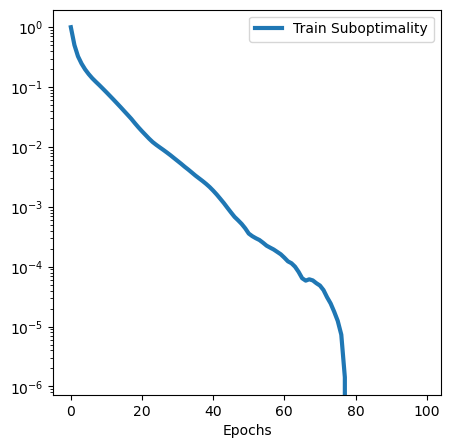

In [11]:
# Display training loss.

fig, ax = plt.subplots(1, 1, figsize=(5, 5))

t = np.arange(len(train_losses))

minimum_loss = output.fun
train_losses = np.array(train_losses)
subopt = (train_losses - minimum_loss) / (train_losses[0] - minimum_loss)

ax.plot(np.arange(len(subopt)), subopt, linewidth=3, label=r"Train Suboptimality")
ax.set_xlabel("Epochs")

ax.legend()
ax.set_yscale("log")
plt.show()

# Compute the Fairness Metrics 

In [12]:
# Test SMD for the law school regression task 
group_label1 = 0
group_label2 = 1
y_pred = torch.matmul(val_obj.X, optimizer.weights.clone().detach())
y_pred_mean = torch.mean(y_pred)
y_pred_g1 = torch.mean(y_pred[group_test==group_label1])
y_pred_g2 = torch.mean(y_pred[group_test==group_label2])
print("Test SMD:", torch.abs(y_pred_g1-y_pred_mean).item() + torch.abs(y_pred_g2-y_pred_mean).item())

Test SMD: 0.036091131113593446


In [13]:
# Test EO for the acs employment classification task
# group_label1 = 1
# group_label2 = 2
# logits = torch.matmul(val_obj.X, optimizer.weights.clone().detach())
# y = logits > 0
# y = torch.where(y, torch.tensor(1), torch.tensor(0))
# eo_1 = torch.mean(y[(val_obj.y == 1) & (group_test == group_label1)].float())
# eo_2= torch.mean(y[(val_obj.y == 1) & (group_test == group_label2)].float())
# print("Test Equal opportunity:", (eo_1-eo_2).item())